In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pylab as plt
import pandas as pd
from bokeh.layouts import row, widgetbox, layout, gridplot
from bokeh.models import CustomJS, Slider
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models.glyphs import MultiLine
from bokeh.io import output_notebook
from bokeh.models.widgets import Div
%matplotlib inline
output_notebook()

Loading BokehJS ...

In [68]:
num_data = 5
X = norm.rvs(size=(num_data,2), random_state=42)
X[:,0]=X[:,0]+5
X = np.dot(X, np.linalg.cholesky([[1, 0.6], [0.6, 0.6]]))
m = X.mean(axis=0)
X = X - m

In [69]:
X

array([[-0.28551678, -0.30882627],
       [ 0.8622341 ,  0.50503833],
       [-1.0739079 , -0.35579408],
       [ 1.3404013 ,  0.13487383],
       [-0.84321071,  0.02470818]])

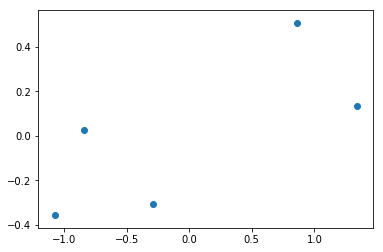

In [70]:
plt.scatter(X[:, 0],X[:, 1])

In [100]:
# numpy covariance matrix (normalized by N)
np.cov(X.T)

array([[1.1214814 , 0.26641932],
       [0.26641932, 0.12395706]])

In [72]:
# X.T*X (not normalized by N)
np.dot(X.T,X)

array([[4.48592561, 1.06567728],
       [1.06567728, 0.49582826]])

In [73]:
e, f = np.linalg.eig(np.dot(X.T, X))

In [74]:
a, b = np.linalg.eig(np.cov(X.T));

In [75]:
# eigenvectors (PCs)
b

array([[ 0.97006433, -0.24284809],
       [ 0.24284809,  0.97006433]])

In [99]:
# eigenvectors (PCs)
f

array([[ 0.97006433, -0.24284809],
       [ 0.24284809,  0.97006433]])

In [101]:
# eigenvalues of cov matrix normed by N
a

array([1.18817741, 0.05726105])

In [106]:
sum(a)

1.2454384654769153

In [102]:
# eigenvalues of cov matrix NOT normed by N
e

array([4.75270966, 0.2290442 ])

In [107]:
sum(e)

4.981753861907661

In [103]:
# bokeh plot

# pre-populate data source object
z0 = np.nan*np.zeros(len(X))
z1 = np.nan*np.zeros(len(X))
x0s = [np.array(np.nan*np.zeros(2)) for i in range(0,len(X))]
x1s = [np.array(np.nan*np.zeros(2)) for i in range(0,len(X))]
d = np.nan*np.zeros(len(X))
dzs = np.zeros(len(X))

# data source
source_data = ColumnDataSource(data=dict(x0=X[:,0], x1=X[:,1], z0=z0, z1=z1, x0s=x0s, x1s=x1s, d=d, dzs=dzs))

# data source for eigenvector line
eig_source = ColumnDataSource(data=dict(e0=np.array([-10*b[0,0], 10*b[0,0]]), e1=np.array([-10*b[1,0], 10*b[1,0]])))

# main plot
plot = figure(x_range=(-2.5, 2.5), y_range=(-2.5, 2.5), plot_width=600, plot_height=600, match_aspect=True)

# plot the new components in the mini-plot on the right
var_plot = figure(x_range=(-5, 5), y_range=(-2.5, 2.5), plot_width = 300, plot_height = 300)
var_plot.scatter('d', 'dzs', source=source_data, color='firebrick', alpha=0.6)

# plot the data
plot.scatter('x0', 'x1', source=source_data, color='navy', alpha=0.6, size=5)

# plot the new axis
plot.line('z0', 'z1', source=source_data, color='black', alpha=0.5)

# plot the projections of the data onto the rotating line
plot.scatter('z0', 'z1', source=source_data, color='firebrick', alpha=0.6)

# plot the line indicating the direction of the first eigenvector
plot.line('e0','e1', source=eig_source, line_width=0.5, line_alpha=0.2)

# plot all the lines connecting the data dots to the projection dots
glyph = MultiLine(xs = "x0s", ys = "x1s", line_color="#8073ac", line_width=1)
plot.add_glyph(source_data, glyph)

# add output text
div = Div(text='Variance along new axis: ', width=200, height=100)

# the javascript code that calculates all the projection dots depending upon the user-chosen angle for the line to project onto
callback = CustomJS(args=dict(source=source_data, div=div), code="""
    var data = source.data;
    var x0 = data['x0']
    var x1 = data['x1']
    
    var d = data['d']
        
    var z0 = data['z0']
    var z1 = data['z1']
    
    var x0s = data['x0s']
    var x1s = data['x1s']
    
    var A = ang.value*Math.PI/180;

    var w = [Math.cos(A), Math.sin(A)];

    for (var i = 0; i < x0.length; i++) {
        d[i] = x0[i]*w[0] + x1[i]*w[1];
        z0[i] = w[0]*d[i];
        z1[i] = w[1]*d[i];
        x0s[i] = [x0[i], z0[i]];
        x1s[i] = [x1[i], z1[i]];
    }

    data['z0'] = z0
    data['z1'] = z1
    data['x0s'] = x0s
    data['x1s'] = x1s
    data['d'] = d
    
    var V = 0
    var line = ""
    for (var j = 0; j < d.length; j++) {
        V = V + Math.pow(d[j], 2);
        line = line + Number(d[j]).toFixed(2) + "\\n"
    }
    
    div.text = "Variance along new axis: " + Number(V).toFixed(2) + "\\nCoordinates along new axis: \\n";
    div.text = div.text + line
    
    source.change.emit();
""")

# make the slider bar
ang_slider = Slider(start=0, end=360, value=1, step=.1, title="Angle", callback=callback)
callback.args["ang"] = ang_slider

# plot layout
lo = layout([
  [plot, [widgetbox(ang_slider), widgetbox(div), var_plot]],
])

# write
output_file("pca.html", title="pca.py example")

# display
show(lo)

[The inspiration](https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues)

In [115]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)
print(pca.components_)  
print(pca.explained_variance_)  

[[ 0.97006433  0.24284809]
 [-0.24284809  0.97006433]]
[1.18817741 0.05726105]


In [116]:
sum(pca.explained_variance_)

1.2454384654769155

In [140]:
pca.explained_variance_[0]*252

299.4207085516162

In [112]:
P = pca.components_.T
P

array([[ 0.97006433, -0.24284809],
       [ 0.24284809,  0.97006433]])

In [114]:
X

array([[-0.28551678, -0.30882627],
       [ 0.8622341 ,  0.50503833],
       [-1.0739079 , -0.35579408],
       [ 1.3404013 ,  0.13487383],
       [-0.84321071,  0.02470818]])

In [143]:
X.shape

(5, 2)

In [120]:
Y = np.dot(P.T, X.T)

In [121]:
Y[0]

array([-0.35196751,  0.95907014, -1.12816366,  1.33302934, -0.8119683 ])

In [122]:
Y

array([[-0.35196751,  0.95907014, -1.12816366,  1.33302934, -0.8119683 ],
       [-0.23024414,  0.28052777, -0.08434667, -0.1946776 ,  0.22874064]])

In [90]:
num_data = 10
Y = norm.rvs(size=(num_data,3), random_state=42)

In [ ]:
Y

In [91]:
from sklearn.decomposition import PCA

class RiskModelPCA():
    
    ANN_FACTOR = 252
    
    def __init__(self, num_factors):
        self._num_factors = num_factors
        self.num_stocks_ = None
        self.factor_betas_ = None
        self.factor_returns_ = None
        self.common_returns_ = None
        self.residuals_ = None
        self.factor_cov_matrix_ = None
        self.idio_var_matrix_ = None
        self.explained_variance_ratio_ = None

    def fit(self, returns):
        self.num_stocks_ = len(returns.columns)
        mod = PCA(n_components=self._num_factors, svd_solver='full')
        mod.fit(returns)
        
        self.factor_betas_ = pd.DataFrame(
            data=mod.components_.T,
            index=returns.columns
        )
        
        self.factor_returns_ = pd.DataFrame(
            data=mod.transform(rets),
            index=returns.index
        )
        
        self.explained_variance_ratio_ = mod.explained_variance_ratio_
        
        self.common_returns_ = pd.DataFrame(
            data=np.dot(self.factor_returns_, self.factor_betas_.T),
            index=returns.index
        )
        self.common_returns_.columns = returns.columns
        
        self.residuals_ = (returns - self.common_returns_)
        
        self.factor_cov_matrix_ = np.diag(
            self.factor_returns_.var(axis=0, ddof=1)*RiskModelPCA.ANN_FACTOR
        )
        
        self.idio_var_matrix_ = pd.DataFrame(
            data=np.diag(np.var(self.residuals_))*RiskModelPCA.ANN_FACTOR,
            index=returns.columns
        )
        
        self.idio_var_vector_ = pd.DataFrame(
            data=np.diag(self.idio_var_matrix_.values),
            index=returns.columns
        )
        
        self.idio_var_matrix_.columns = index=returns.columns

    def get_factor_exposures(self, weights):
        F = self.factor_betas_.loc[weights.index]
        return F.T.dot(weights)

    def predict(self, weights):
        """ Calculates expected portfolio risk as sqrt(h'XFX'h + h'Sh).
            This will fail if your portfolio has asset weights not in the risk model"""
        all_assets = pd.DataFrame(
            data=np.repeat(0, self.num_stocks_),
            index=self.factor_betas_.index)
        all_assets.loc[weights.index] = weights
        
            
        h = all_assets
        X = self.factor_betas_
        F = self.factor_cov_matrix_
        S = self.idio_var_matrix_
        
        return np.sqrt(h.T.dot(X).dot(F).dot(X.T).dot(h) + h.T.dot(S).dot(h))[0].values[0]



In [130]:
rets = pd.DataFrame(X)
rets.columns = ['AAPL','GOOG']
rets

,AAPL,GOOG
0,-0.285517,-0.308826
1,0.862234,0.505038
2,-1.073908,-0.355794
3,1.340401,0.134874
4,-0.843211,0.024708


In [149]:
rm = RiskModelPCA(2)
rm.fit(rets)

In [150]:
# factor betas are the PCs to keep
rm.factor_betas_

,0,1
AAPL,0.970064,-0.242848
GOOG,0.242848,0.970064


In [151]:
# factor betas are orthogonal to idiosyncratic variance vecs
np.dot(rm.factor_betas_.T, rm.residuals_.T)

array([[-2.28878328e-16, -1.07698775e-16, -4.30795102e-16,
         0.00000000e+00, -4.34165296e-16],
       [ 7.37206160e-20,  2.69615542e-17,  1.07846217e-16,
         0.00000000e+00,  9.43838698e-17]])

In [152]:
# factor returns are the transformed data—the returns in the new basis, condensed
rm.factor_returns_

,0,1
0,-0.351968,-0.230244
1,0.959070,0.280528
2,-1.128164,-0.084347
3,1.333029,-0.194678
4,-0.811968,0.228741


In [154]:
np.dot(rm.factor_returns_.T, rm.factor_returns_)

array([[4.75270966e+00, 1.99212200e-16],
       [1.99212200e-16, 2.29044202e-01]])

In [126]:
rm.explained_variance_ratio_

array([0.95402338])

In [136]:
# dimensionally-reduced returns in feature space
rm.common_returns_

,AAPL,GOOG
0,-0.341431,-0.085475
1,0.930360,0.232908
2,-1.094391,-0.273972
3,1.293124,0.323724
4,-0.787661,-0.197185


In [137]:
#
rm.residuals_

,AAPL,GOOG
0,0.055914,-0.223352
1,-0.068126,0.272130
2,0.020483,-0.081822
3,0.047277,-0.188850
4,-0.055549,0.221893


In [147]:
(1/5)*np.dot(rm.residuals_.T, rm.residuals_)

array([[ 0.00270159, -0.01079157],
       [-0.01079157,  0.04310726]])

In [138]:
# eigenvalue 1 * 252
rm.factor_cov_matrix_

array([[299.42070855]])

In [141]:
#
rm.idio_var_matrix_

,AAPL,GOOG
AAPL,0.680799,0.000000
GOOG,0.000000,10.863028


In [142]:
np.var(rm.residuals_)

AAPL    0.002702
GOOG    0.043107
dtype: float64